In [57]:
#Importing necessary modules
import pandas as pd
import numpy as np
import nltk
from pattern.en import tag
from nltk.corpus import wordnet
import pattern 
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import seaborn as sn
import matplotlib.pyplot as plt
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
#Loading the disaster tweets training set
train=pd.read_csv(r'C:\Users\ds8\AppData\Local\Programs\Python\Python36\text_Analysys_Data\train_desaster_tweet.csv')

In [4]:
#Visualize the top 10 examples
train.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [5]:
train.shape

(7613, 5)

In [6]:
#Check the missing values quatities per feature
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

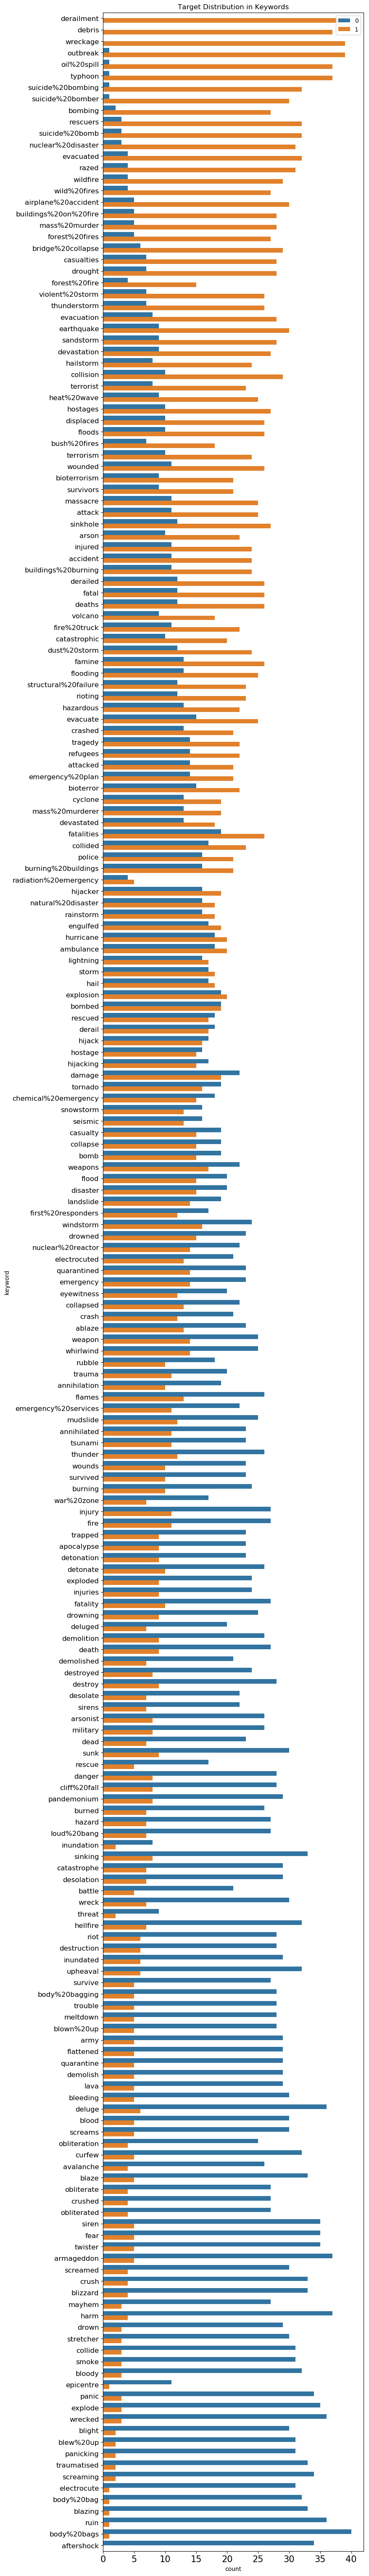

In [13]:
#Build a countplot to see how keywords are correlated to the target variable (disaster/non disaster tweet)
train['target_mean'] = train.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 80), dpi=100)

sn.countplot(y=train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=train.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

In [14]:
#Remove special caracters, emoticons and so on
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)

In [25]:
#Keep only text and target variable for model building
xtrain=train.loc[:,['text','target']]

In [26]:
xtrain['text_clean'] = xtrain['text'].apply(lambda x: remove_URL(x))
xtrain['text_clean'] = xtrain['text_clean'].apply(lambda x: remove_emoji(x))
xtrain['text_clean'] = xtrain['text_clean'].apply(lambda x: remove_html(x))

In [17]:
xtrain.head(10)

,text,target,text_clean
0,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake M...
1,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada
2,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' are ...
3,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or..."
4,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby #Alaska as ...
5,#RockyFire Update => California Hwy. 20 closed...,1,#RockyFire Update => California Hwy. 20 closed...
6,#flood #disaster Heavy rain causes flash flood...,1,#flood #disaster Heavy rain causes flash flood...
7,I'm on top of the hill and I can see a fire in...,1,I'm on top of the hill and I can see a fire in...
8,There's an emergency evacuation happening now ...,1,There's an emergency evacuation happening now ...
9,I'm afraid that the tornado is coming to our a...,1,I'm afraid that the tornado is coming to our a...


In [27]:
#remove non alphabetic caracter
xtrain.text_clean.replace(r'[^a-zA-Z]', ' ', regex=True, inplace=True)
xtrain.head(10)

,text,target,text_clean
0,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake M...
1,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada
2,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are ...
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation or...
4,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as ...
5,#RockyFire Update => California Hwy. 20 closed...,1,RockyFire Update California Hwy closed...
6,#flood #disaster Heavy rain causes flash flood...,1,flood disaster Heavy rain causes flash flood...
7,I'm on top of the hill and I can see a fire in...,1,I m on top of the hill and I can see a fire in...
8,There's an emergency evacuation happening now ...,1,There s an emergency evacuation happening now ...
9,I'm afraid that the tornado is coming to our a...,1,I m afraid that the tornado is coming to our a...


In [28]:
#Define contraction map and map it on our text data
#@author: DIP
CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}
def expand_contractions(sentence, contraction_mapping=CONTRACTION_MAP):
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, sentence)
    return expanded_text

In [29]:
xtrain['text_clean']=xtrain['text_clean'].map(expand_contractions)
xtrain.head()

,text,target,text_clean
0,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake M...
1,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada
2,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are ...
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation or...
4,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as ...


In [30]:
#tokenizet the cleaned data
xtrain["tokenized_text_clean"] = xtrain["text_clean"].map(nltk.word_tokenize)
xtrain.head(10)

,text,target,text_clean,tokenized_text_clean
0,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake M...,"[Our, Deeds, are, the, Reason, of, this, earth..."
1,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]"
2,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are ...,"[All, residents, asked, to, shelter, in, place..."
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation or...,"[people, receive, wildfires, evacuation, order..."
4,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as ...,"[Just, got, sent, this, photo, from, Ruby, Ala..."
5,#RockyFire Update => California Hwy. 20 closed...,1,RockyFire Update California Hwy closed...,"[RockyFire, Update, California, Hwy, closed, i..."
6,#flood #disaster Heavy rain causes flash flood...,1,flood disaster Heavy rain causes flash flood...,"[flood, disaster, Heavy, rain, causes, flash, ..."
7,I'm on top of the hill and I can see a fire in...,1,I m on top of the hill and I can see a fire in...,"[I, m, on, top, of, the, hill, and, I, can, se..."
8,There's an emergency evacuation happening now ...,1,There s an emergency evacuation happening now ...,"[There, s, an, emergency, evacuation, happenin..."
9,I'm afraid that the tornado is coming to our a...,1,I m afraid that the tornado is coming to our a...,"[I, m, afraid, that, the, tornado, is, coming,..."


In [32]:
#Correct repeated character, like Loooool to Lol, amaziiing to amazing and so on
def corect_word_with_repeated_characters(tokens):
    repeat_pattern = re.compile(r'(\w*)(\w)\2(\w*)')
    match_substitution = r'\1\2\3'
    def replace(old_word):
        if wordnet.synsets(old_word):
            return old_word
        new_word = repeat_pattern.sub(match_substitution, old_word)
        return replace(new_word) if new_word != old_word else new_word
    correct_tokens = [replace(word) for word in tokens]
    return correct_tokens

In [38]:
#A simple test
remove_repeated_characters(['Loooooool', 'this', 'is', 'amaaaaziing'])

['Lol', 'this', 'is', 'amazing']

In [39]:
xtrain['corected_tokenized']=xtrain['tokenized_text_clean'].map(corect_word_with_repeated_characters)
xtrain.tail()

,text,target,text_clean,tokenized_text_clean,corected_tokenized
7608,Two giant cranes holding a bridge collapse int...,1,Two giant cranes holding a bridge collapse int...,"[Two, giant, cranes, holding, a, bridge, colla...","[Two, giant, cranes, holding, a, bridge, colla..."
7609,@aria_ahrary @TheTawniest The out of control w...,1,aria ahrary TheTawniest The out of control w...,"[aria, ahrary, TheTawniest, The, out, of, cont...","[aria, ahrary, TheTawniest, The, out, of, cont..."
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,M UTC km S of Volcano Hawaii,"[M, UTC, km, S, of, Volcano, Hawaii]","[M, UTC, km, S, of, Volcano, Hawaii]"
7611,Police investigating after an e-bike collided ...,1,Police investigating after an e bike collided ...,"[Police, investigating, after, an, e, bike, co...","[Police, investigating, after, an, e, bike, co..."
7612,The Latest: More Homes Razed by Northern Calif...,1,The Latest More Homes Razed by Northern Calif...,"[The, Latest, More, Homes, Razed, by, Northern...","[The, Latest, More, Homes, Razed, by, Northern..."


In [40]:
#Reconcatate tokens into sentences
def reconcat(data):
    return (" ").join(data)

In [44]:
#remove stop words from tokens and reconcatenate tokens into sentences
stop=stopwords.words('english')
xtrain["remove_stop_text"] =xtrain["corected_tokenized"].apply(lambda x: [item for item in x if item not in stop])
xtrain['remove_stop_text']=xtrain['remove_stop_text'].map(reconcat)


In [45]:
xtrain.head()

,text,target,text_clean,tokenized_text_clean,corected_tokenized,remove_stop_text
0,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake M...,"[Our, Deeds, are, the, Reason, of, this, earth...","[Our, Deeds, are, the, Reason, of, this, earth...",Our Deeds Reason earthquake May ALLAH Forgive us
1,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]","[Forest, fire, near, La, Ronge, Sask, Canada]",Forest fire near La Ronge Sask Canada
2,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are ...,"[All, residents, asked, to, shelter, in, place...","[All, residents, asked, to, shelter, in, place...",All residents asked shelter place notified off...
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation or...,"[people, receive, wildfires, evacuation, order...","[people, receive, wildfires, evacuation, order...",people receive wildfires evacuation orders Cal...
4,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as ...,"[Just, got, sent, this, photo, from, Ruby, Ala...","[Just, got, sent, this, photo, from, Ruby, Ala...",Just got sent photo Ruby Alaska smoke wildfire...


In [53]:
# Annotate text tokens with POS tags
def pos_tag_text(text):
    
    def penn_to_wn_tags(pos_tag):
        if pos_tag.startswith('J'):
            return wn.ADJ
        elif pos_tag.startswith('V'):
            return wn.VERB
        elif pos_tag.startswith('N'):
            return wn.NOUN
        elif pos_tag.startswith('R'):
            return wn.ADV
        else:
            return None
    
    tagged_text = tag(text)
    tagged_lower_text = [(word.lower(), penn_to_wn_tags(pos_tag))
                         for word, pos_tag in
                         tagged_text]
    return tagged_lower_text
    
# lemmatize text based on POS tags    
def lemmatize_text(text):
    from nltk.stem import WordNetLemmatizer
    wnl = WordNetLemmatizer()
    pos_tagged_text = pos_tag_text(text)
    lemmatized_tokens = [wnl.lemmatize(word, pos_tag) if pos_tag
                         else word                     
                         for word, pos_tag in pos_tagged_text]
    lemmatized_text = ' '.join(str(v) for v in lemmatized_tokens)
    return lemmatized_text

In [54]:
xtrain["lematize_tokenized"] =xtrain["remove_stop_text"].map(lemmatize_text)

In [55]:
xtrain.head()

,text,target,text_clean,tokenized_text_clean,corected_tokenized,remove_stop_text,lematize_tokenized
0,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake M...,"[Our, Deeds, are, the, Reason, of, this, earth...","[Our, Deeds, are, the, Reason, of, this, earth...",Our Deeds Reason earthquake May ALLAH Forgive us,our deed reason earthquake may allah forgive us
1,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]","[Forest, fire, near, La, Ronge, Sask, Canada]",Forest fire near La Ronge Sask Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are ...,"[All, residents, asked, to, shelter, in, place...","[All, residents, asked, to, shelter, in, place...",All residents asked shelter place notified off...,all resident asked shelter place notified offi...
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation or...,"[people, receive, wildfires, evacuation, order...","[people, receive, wildfires, evacuation, order...",people receive wildfires evacuation orders Cal...,people receive wildfire evacuation order calif...
4,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as ...,"[Just, got, sent, this, photo, from, Ruby, Ala...","[Just, got, sent, this, photo, from, Ruby, Ala...",Just got sent photo Ruby Alaska smoke wildfire...,just get send photo ruby alaska smoke wildfire...


In [56]:
#Define metric function for evaluating our classification model
def get_metrics(labels, predicted_labels):
    print('Accuracy:', np.round(metrics.accuracy_score(labels,predicted_labels), 3))
    print('Precision:', np.round(metrics.precision_score(labels,predicted_labels,average='weighted'),3))
    print('Recall:', np.round(metrics.recall_score(labels, predicted_labels,average='weighted'),3))
    print('F1 Score:', np.round(metrics.f1_score(labels,predicted_labels,average='weighted'),3))

In [58]:
#Define a tfidf extractor
def tfidf_extractor(corpus, ngram_range=(1,1)):
    
    vectorizer = TfidfVectorizer(min_df=1, 
                                 norm='l2',
                                 smooth_idf=True,
                                 use_idf=True,
                                 ngram_range=ngram_range)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features

In [59]:
# Display features on a pandas dataframe
def display_features(features, feature_names):
    df = pd.DataFrame(data=features,
    columns=feature_names)
    return df

In [60]:
transformer, tfidf_matrix=tfidf_extractor(xtrain['lematize_tokenized'])

In [61]:
tfidf_matrix=tfidf_matrix.toarray()

In [62]:
feature_names=transformer.get_feature_names()

In [63]:
X=display_features(tfidf_matrix, feature_names)
X.head()

,aa,aaa,aamir,aand,aar,aaronthefm,aashiqui,ab,aba,abandon,...,zone,zonewolf,zoom,zotar,zouma,zouryart,zrnf,zumiez,zurich,zxathetis
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
#Build and train a classifier
def train_predict_evaluate_model(classifier, train_features, train_labels,test_features, test_labels):
    # build model
    classifier.fit(train_features, train_labels)
    # predict using model
    predictions = classifier.predict(test_features)
    # evaluate model prediction performance
    get_metrics(labels=test_labels,predicted_labels=predictions)
    return predictions

In [67]:
ytrain=xtrain['target']
#Decompose training data into train and test set
train_X, test_X, train_Y, test_Y = train_test_split(X, ytrain, test_size=0.30)

In [68]:
#use a simple naive Bayes classifier
mnb = MultinomialNB()

In [71]:
ypred = train_predict_evaluate_model(mnb,train_X,train_Y,test_X,test_Y)

Accuracy: 0.804
Precision: 0.808
Recall: 0.804
F1 Score: 0.8


In [74]:
""""We can also leave emoticons like that instead of removing them. In this particular dataset,
     it gives
    better results, which is normal since emoticons also indicated a
    negative or positive character"""


'"We can also leave emoticons like that instead of removing them. In this particular dataset, it gives\n    better results, which is normal since emoticons also indicated a\n    negative or positive character'